Bayesian Logistic Regression

* https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-logistic.html


<br>

## Preliminaries

In [1]:
%%bash

rm -rf *.sh
rm -rf trace.zip
rm -rf warehouse

<br>
<br>

### Packages & Libraries

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/exhypotheses/risk/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Libraries**

In [4]:
import logging
import collections
import os
import zipfile
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano
import pymc3
import graphviz
import arviz as az

import pickle
import json


<br>
<br>

### Logging

In [5]:
logging.basicConfig(level=logging.INFO, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

### Custom

In [6]:
import config

import risk.graphing.relational
import risk.graphing.settings

import risk.functions.sample
import risk.functions.scale

import risk.evaluations.dag

<br>

Configurations

In [7]:
configurations = config.Config()

<br>

Graphs

In [8]:
relational = risk.graphing.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [9]:
settings = risk.graphing.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

Paths

In [10]:
if not 'google.colab' in str(get_ipython()):    
    notebooks = os.getcwd()
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)
else:
    parent = os.getcwd()  

In [11]:
directory = os.path.join(configurations.warehouse, 'model')

if not os.path.exists(directory):
    os.makedirs(directory)

<br>
<br>

## For YAML

* 'problem': 'Binary Classification'
* 'modelType': 'Bayesian Logistic Model'

### Seed

In [12]:
SEED = 5
np.random.seed(seed=SEED)

<br>

### Modelling Parameters, Variables, Arguments

Cases:

* **Include**:<br>['duration_months', 'credit_amount', 'e_chq_acc_status', 'credit_history', 'purpose', 'savings_acc_class', 'property', 'housing']


* **Either**:<br>['curr_emp_class']

* **Exclude**:<br>['i_rate_by_disp_inc', 'curr_res_since', 'age_years', 'n_e_credits_this_bank', 'n_dependants', 'sex_and_status', 'other_debtors_class', 'other_i_plans', 'job', 'telephone', 'foreign_worker', 'female']


In [13]:
include = ['duration_months', 'credit_amount', 'e_chq_acc_status_1', 'e_chq_acc_status_2', 
           'credit_history_1', 'credit_history_2', 'purpose_1', 'purpose_2',
           'savings_acc_class_1', 'savings_acc_class_2', 
           'housing_1', 'housing_2', 'reasonable']
binary_cf = ['A192', 'A201', 'female']
target = 'reasonable'

<br>
<br>

## Data

### Read

Reads in the data wherein the polytomous categorical fields have undergone t-SNE embedding.

In [14]:
url_mappings = 'https://raw.githubusercontent.com/exhypotheses/risk/develop/warehouse/splits/scikit/mappings.json'
url_training = 'https://raw.githubusercontent.com/exhypotheses/risk/develop/warehouse/splits/scikit/training.csv'

<br>

Mappings

In [15]:
try:
    req = requests.get(url=url_mappings)
    req.raise_for_status
except requests.exceptions.RequestException as err:
    raise Exception(err)

mappings = json.loads(req.content)     

<br>

Training Data

In [16]:
try:
    trainingdata = pd.read_csv(
        filepath_or_buffer=url_training, header=0, encoding='utf-8', 
        dtype={'A192': np.uint8, 'A201': np.uint8, 'female': np.uint8, 'reasonable': np.uint8})
except OSError as err:
    raise Exception(err.strerror)    

In [17]:
training = trainingdata.copy().drop(columns=list(mappings.keys()))
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   duration_months        650 non-null    int64  
 1   credit_amount          650 non-null    int64  
 2   i_rate_by_disp_inc     650 non-null    int64  
 3   curr_res_since         650 non-null    int64  
 4   age_years              650 non-null    int64  
 5   n_e_credits_this_bank  650 non-null    int64  
 6   n_dependants           650 non-null    int64  
 7   e_chq_acc_status_1     650 non-null    float64
 8   e_chq_acc_status_2     650 non-null    float64
 9   credit_history_1       650 non-null    float64
 10  credit_history_2       650 non-null    float64
 11  purpose_1              650 non-null    float64
 12  purpose_2              650 non-null    float64
 13  savings_acc_class_1    650 non-null    float64
 14  savings_acc_class_2    650 non-null    float64
 15  curr_e

<br>

### Structure

**Scale**

Via sklearn.preprocessing.StandardScaler

In [18]:
scale = risk.functions.scale.Scale()

In [19]:
scaler = scale.exc(blob=training.drop(columns=target))
left = scale.apply(blob=training.drop(columns=target), scaler=scaler)
scaled = pd.concat((left, training[target]), axis=1, ignore_index=False)
scaled.shape

(650, 33)

<br>
<br>

**Sample**

Via imblearn.over_sampling.SVMSMOTE

In [20]:
sample = risk.functions.sample.Sample()
sampled = sample.exc(blob=scaled, target=target)

logger.warning('Shape: {}'.format(sampled.shape))
logger.warning('\nBreakdown:\n{}'.format(sampled.reasonable.value_counts()))

Shape: (910, 33)
2021-08-04 22:59:44.002

Breakdown:
1    455
0    455
Name: reasonable, dtype: int64
2021-08-04 22:59:44.006


<br>
<br>

## Model

In [21]:
baseline = sampled[include]
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   duration_months      910 non-null    float64
 1   credit_amount        910 non-null    float64
 2   e_chq_acc_status_1   910 non-null    float64
 3   e_chq_acc_status_2   910 non-null    float64
 4   credit_history_1     910 non-null    float64
 5   credit_history_2     910 non-null    float64
 6   purpose_1            910 non-null    float64
 7   purpose_2            910 non-null    float64
 8   savings_acc_class_1  910 non-null    float64
 9   savings_acc_class_2  910 non-null    float64
 10  housing_1            910 non-null    float64
 11  housing_2            910 non-null    float64
 12  reasonable           910 non-null    uint8  
dtypes: float64(12), uint8(1)
memory usage: 86.3 KB


<br>

Hence

In [22]:
training_ = baseline

In [23]:
x_training_fields = list(baseline.drop(columns=target).columns)
x_training_ = baseline[x_training_fields].to_numpy()
y_training_ = baseline[target].to_numpy()

<br>
<br>

### Define

* https://docs.pymc.io/api/inference.html#module-pymc3.sampling


Initially

In [24]:
xshared = theano.shared(x_training_)

<br>

Therefore

In [ ]:
with pymc3.Model() as lm:

    pymc3.glm.GLM(x=xshared, y=y_training_, intercept=True, labels=x_training_fields, 
                  priors={'Regressor': pymc3.StudentT.dist(nu=5.0, mu=0, sigma=15.0)}, 
                  family=pymc3.families.Binomial())
    
    # Trace
    trace = pymc3.sample(tune=1000, draws=2000)

    # The trace generated from MCMC sampling
    arviztrace = az.from_pymc3(trace=trace)

<br>

**DAG**

Lock 140380398645648 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.832
Lock 140380398645648 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.834
Lock 140380441918096 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.850
Lock 140380441918096 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.851
Lock 140380442178000 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.868
Lock 140380442178000 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
2021-08-04 23:01:22.869
Lock 140380442208080 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubu

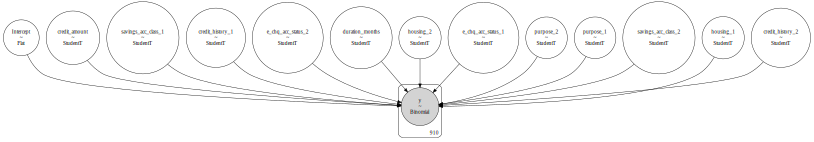

In [26]:
dag = risk.evaluations.dag.DAG()
dag.exc(model=lm, directory=directory)

<br>
<br>

### Trace

**Variables**

In [27]:
', '.join(trace.varnames)

'Intercept, duration_months, credit_amount, e_chq_acc_status_1, e_chq_acc_status_2, credit_history_1, credit_history_2, purpose_1, purpose_2, savings_acc_class_1, savings_acc_class_2, housing_1, housing_2'

<br>

**Graphs**

* plt.rcParams

* Ascertain `{'figure.constrained_layout.use': True}`

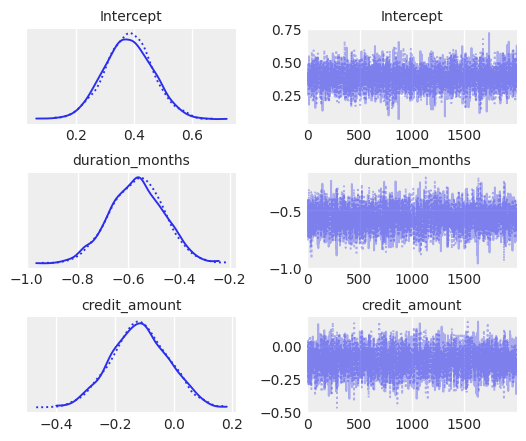

In [28]:
plt.rcParams.update({'font.size': 11, 'ytick.labelsize': 11, 'xtick.labelsize': 11, 
                     'axes.titlesize': 11, 'figure.subplot.hspace': 0.4})

with lm:
    az.plot_trace(data=arviztrace, figsize=(5.15, 4.30), 
                  var_names=['Intercept', 'duration_months', 'credit_amount'])

<br>

**Posterior Graphs** (cf. Default Trace Graphs)

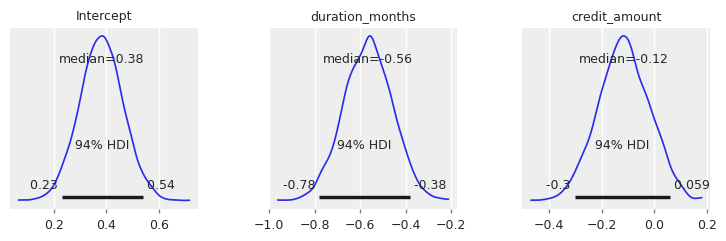

In [29]:
plt.rcParams.update({'font.size': 11, 'axes.labelsize': 11.0, 'figure.constrained_layout.wspace': 0.2})

with lm:
    pymc3.plot_posterior(data=trace, var_names=['Intercept', 'duration_months', 'credit_amount'], 
                         figsize=(7.15, 2.3), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

## Persist

### Assets

**Pre-transforms training data**

In [30]:
trainingdata.to_csv(path_or_buf=os.path.join(directory, 'training.csv'), 
                    header=True, index=False, encoding='UTF-8')

<br>

**Sampled**

In [31]:
sampled.to_csv(path_or_buf=os.path.join(directory, 'sampled.csv'), 
               header=True, index=False, encoding='UTF-8')

<br>

**Determine Binary Maps**

In [32]:
dictionary = {}

for element in binary_cf:

    pairings = pd.concat((training[element], scaled[element]), axis=1, ).drop_duplicates()
    pairings.set_axis(labels=['state', element], axis=1, inplace=True)
    mapping = pairings.set_index(keys='state', drop=True).to_dict(orient='dict')

    dictionary.__setitem__(element, mapping[element])

<br>

**Pocket**

In [33]:
pocket = {
    'lm': lm,
    'ndraws': trace.report.n_draws,
    'nchains': trace.nchains,
    'xshared': xshared,
    'target': target, 
    'regressors': ','.join(x_training_fields),
    'binary_cf_dictionary': dictionary,
    'scaler': scaler 
}

<br>

**Assets**

In [34]:
class Assets:

    def __init__(self, directory: str):
        """
        
        """

        self.directory = directory

    def pocket_(self, pocket: dict):

        pickled = pickle.dumps(pocket)        
        f = open(os.path.join(self.directory, 'pocket.pkl'), mode='wb')        
        f.write(pickled)
        f.close()

    def trace_(self, trace: pymc3.backends.base.MultiTrace):
        """
        Reloading requires the model context, excellent.

        :param trace:
        """

        pymc3.backends.ndarray.save_trace(
            trace=trace, directory=os.path.join('trace'), overwrite=True)
        
        tracefiles = []
        for base, directories, files in os.walk(os.path.join('trace')):
            for file in files:
                tracefiles.append(os.path.join(base, file))

        with zipfile.ZipFile(file='trace.zip', mode='w', compression=zipfile.ZIP_DEFLATED, allowZip64=False, compresslevel=6) as tr:
            for tracefile in tracefiles:
                tr.write(tracefile)


In [35]:
assets = Assets(directory=directory)
assets.pocket_(pocket=pocket)
assets.trace_(trace=trace)

<br>
<br>

### ArViz

```python
arviztrace.to_json(os.path.join(directory, 'arviz.json'))
```

<br>
<br>

## End

In [36]:
%%bash

TZ=UTC-1 date +"%Y-%m-%d %T"

2021-08-05 00:01:31
